# Inspecting clinical images for radiomic feature extraction

The very first step of any radiomics pipeline is visualising images.

While this can be laborious and time-consuming, it gives us a good impression of what exactly is present in the data - and this includes the annotations!

## Loading Python libraries

Python libraries are collections of programming routines aimed towards a common goal.

In this notebook we will be using the following packages:

- `numpy`, one of the most popular programming libraries in Python, is typically used for generic mathematical operations using vectors, matrices and arrays in Python
- `SimpleITK` is a Python library for medical imaging manipulation. It can read volumes, resample volumes to different orientations, spacings and to a common physical space, co-register different imaging modalities and perform simple thresholding operations
- `display_lib` is a custom library developed for this course that allows for the visualization of volumes inside Jupyter Notebooks

[Jupyter Notebooks](https://jupyter.org/) are web-based interactive programming applications in Python. They are useful to carefully document code and for presentations such as these.

In [1]:
%%capture
%matplotlib inline

import SimpleITK as sitk
import numpy as np
from display_lib import VolumeDisplay, resample

## Visualising data

Below we are presenting how a simple visualizer operates. Through simple interactive controls, we can actually visualize everything and trigger different aspects of our data!

We will be working with [WAW-TACE](https://pubs.rsna.org/doi/10.1148/ryai.240296), a hepatocellular carcinoma (HCC) multiphase CT dataset. This dataset contains HCC segmentation annotations, which will be used to extract radiomic features, and other important clinical data which we will later use as targets.

For now, let's take a look at one of the cases:

interactive(children=(IntSlider(value=0, description='Slice index', max=162), ToggleButton(value=False, descri…

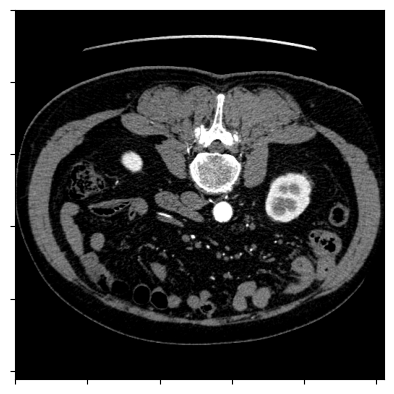

In [2]:
# let's define here the folder where all of the data is (as retrieved from the Zenodo repository)
# i.e. https://zenodo.org/records/12741586
image_path = "/big_disk/Datasets/WAW-TACE"
# let's define here a patient identifier
patient_id = "10"

# here we create a dictionary relating different images or the mask to the path
image_paths = {
    "pre": f"{image_path}/{patient_id}/{patient_id}_0_scan.nii.gz",
    "arterial": f"{image_path}/{patient_id}/{patient_id}_1_scan.nii.gz",
    "portal": f"{image_path}/{patient_id}/{patient_id}_2_scan.nii.gz",
    "mask": f"{image_path}/tumor_masks_wawtace_v1_08_05_2024/{patient_id}/{patient_id}_2_0_tumor_seg.nrrd"
}

# here we use the volume displayer to actually see a scan.
# since abdominal CT scans can be relatively large, we may have to wait a few scans before they are opened
vol_display = VolumeDisplay(
    paths=[image_paths["arterial"], image_paths["portal"]], 
    mask_path=image_paths["mask"])

vol_display()

## Collecting all cases

OK, now that we have been able to inspect some cases, we will focus on performing a small set of operations anticipating the radiomics feature extraction:

1. **Identify a common spacing** - different centers or protocols will use different spacings. Small changes to this may not have an impact on how radiologists interpret CT studies, but are likely to affect radiomic features. As such, we start by extracting the relevant spacing information
2. **Identify the minimum pixel value** - some radiomic features and image transformations are not very appropriate for negative values. For this reason, we will be shifting all values in the image to be positive
3. **Identify which cases are missing which series types** - after having a loose understanding of image characteristics, we will finally understand which phases are available for each patient

### Creating a dictionary with all cases

In [3]:
import os # library to interact with the operating system
from pathlib import Path # library to work with paths

# this defines a path object which we will use to recursively search for volumes
dataset_path = Path(image_path)

patient_phase_dictionary = {}

# this will collect all the volumes.
# we know that the relevant volumes have "_scan" in their name, so we will be filtering accordingly.
for volume_path in dataset_path.rglob("*nii.gz"):
    volume_path = str(volume_path)
    if "_scan" in volume_path:
        patient_id = volume_path.split(os.sep)[-2]
        if patient_id not in patient_phase_dictionary:
            patient_phase_dictionary[patient_id] = {}
        phase_id = volume_path.split(os.sep)[-1].split("_")[-2]
        patient_phase_dictionary[patient_id][phase_id] = volume_path

for volume_path in dataset_path.rglob("*nrrd"):
    volume_path = str(volume_path)
    patient_id = volume_path.split(os.sep)[-2]
    if patient_id in patient_phase_dictionary:
        if "masks" not in patient_phase_dictionary[patient_id]:
            patient_phase_dictionary[patient_id]["masks"] = []
        patient_phase_dictionary[patient_id]["masks"].append(volume_path)

print("Length of patient dictionary:", len(patient_phase_dictionary))
print("Number of patients with pre-contrast phase:", len([k for k in patient_phase_dictionary if "0" in patient_phase_dictionary[k]]))
print("Number of patients with arterial phase:", len([k for k in patient_phase_dictionary if "1" in patient_phase_dictionary[k]]))
print("Number of patients with portal phase:", len([k for k in patient_phase_dictionary if "2" in patient_phase_dictionary[k]]))
print("Number of patients with post-contrast phase:", len([k for k in patient_phase_dictionary if "3" in patient_phase_dictionary[k]]))
print("Number of patients with masks:", len([k for k in patient_phase_dictionary if "masks" in patient_phase_dictionary[k]]))

print("Number of patients with arterial and portal phases and masks:", 
      len([
          k for k in patient_phase_dictionary 
          if "1" in patient_phase_dictionary[k] and "2" in patient_phase_dictionary[k] and "masks" in patient_phase_dictionary[k]]))

Length of patient dictionary: 233
Number of patients with pre-contrast phase: 200
Number of patients with arterial phase: 230
Number of patients with portal phase: 231
Number of patients with post-contrast phase: 193
Number of patients with masks: 233
Number of patients with arterial and portal phases and masks: 229


### Extracting minimum intensity and spacing for all cases

In [4]:
from tqdm import tqdm # this is a progress bar - helpful to see how we are doing!

arterial_min_filter = sitk.MinimumMaximumImageFilter()
portal_min_filter = sitk.MinimumMaximumImageFilter()
property_dictionary = {}

for patient in tqdm(patient_phase_dictionary):
    # check if both arterial and portal are available
    if "1" in patient_phase_dictionary[patient] and "2" in patient_phase_dictionary[patient]:
        arterial_path = patient_phase_dictionary[patient]["1"]
        portal_path = patient_phase_dictionary[patient]["2"]
        arterial_image, portal_image = sitk.ReadImage(arterial_path), sitk.ReadImage(portal_path)
        arterial_min_filter.Execute(arterial_image)
        portal_min_filter.Execute(portal_image)
        property_dictionary[patient] = {
            "Arterial": {
                "path": arterial_path,
                "spacing": arterial_image.GetSpacing(),
                "minimum": arterial_min_filter.GetMinimum()
            },
            "Portal": {
                "path": portal_path,
                "spacing": portal_image.GetSpacing(),
                "minimum": portal_min_filter.GetMinimum()
            }
        }

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 233/233 [04:28<00:00,  1.15s/it]


### Picking a within-plane spacing

Now that we have the spacing information for all images we have to make a decision: we know we need a common spacing. But different spacings come with compromises:

- Picking the **minimum spacing** (highest resolution) - if this is applied to instances where the resolution is lower we will probably _create information_! By trying to increase the image resolution artificially, missing pixels and voxels are filled in with an educated guess. However, this can introduce biases!
- Picking the **maximum spacing** (lowest resolution) - if this is applied to instances where the resolution is higher we will probably _lose information_!
- Picking the **median spacing** - this is also intuitive, we try to achieve a compromise by upsampling some images and downsampling others. But we are still running a similar set of risks

Ultimately this is a matter of **protocol design**: there is no _a priori_ correct answer but consistency matters. In other words, while the ideal solution is hard to determine, we are OK as long as we are consistent.

To determine which method works best: empircally assess this for your use case! Maybe there is an ideal solution, maybe there isn't.

#### Our (heuristic) solution

Let's use the maximum spacing (lowest resolution). Since these tumours are relatively large, we should be losing little when we downsample them.

In [5]:
arterial_spacing_array = np.array([property_dictionary[k]["Arterial"]["spacing"] for k in property_dictionary])
portal_spacing_array = np.array([property_dictionary[k]["Arterial"]["spacing"] for k in property_dictionary])

for q in [0, 0.5, 1.0]:
    print(f"Spacing at quantile={q} (arterial):", np.quantile(arterial_spacing_array, q, axis=0))
    print(f"Spacing at quantile={q} (portal):", np.quantile(portal_spacing_array, q, axis=0))

Spacing at quantile=0 (arterial): [0.54296899 0.54296899 0.5       ]
Spacing at quantile=0 (portal): [0.54296899 0.54296899 0.5       ]
Spacing at quantile=0.5 (arterial): [0.77929699 0.77929699 1.25      ]
Spacing at quantile=0.5 (portal): [0.77929699 0.77929699 1.25      ]
Spacing at quantile=1.0 (arterial): [1.07500005 1.07500005 5.        ]
Spacing at quantile=1.0 (portal): [1.07500005 1.07500005 5.        ]


### Picking a between-plane spacing

These images are not isometric (their spacing is not identical in all directions): only the xy (within-plane) spacing is identical, whereas the z (between-plane) spacing is different.

Is this yet another decision we have to make? 😱

Luckily, not really - while features can be extracted in 3 dimensions, we can force radiomic feature extraction to work with 2D features. This allows us to preserve the original between-plane spacing without introducing any biases from the resampling.

## Radiomic feature extraction

Now that we have a rough idea of the parameters necessary for radiomic feature extraction we can start extracting radiomic features!

First let's define constants for the minimum values and for the spacing we want to apply to our radiomic feature extraction.

In [6]:
arterial_spacing = np.max(arterial_spacing_array, axis=0)[:2]
portal_spacing = np.max(portal_spacing_array, axis=0)[:2]
arterial_minimum_value = min([property_dictionary[k]["Arterial"]["minimum"] for k in property_dictionary])
portal_minimum_value = min([property_dictionary[k]["Portal"]["minimum"] for k in property_dictionary])

print("Arterial spacing:", arterial_spacing)
print("Portal spacing:", portal_spacing)
print("Arterial minimum value:", arterial_minimum_value)
print("Portal minimum value:", portal_minimum_value)

Arterial spacing: [1.07500005 1.07500005]
Portal spacing: [1.07500005 1.07500005]
Arterial minimum value: -10226.0
Portal minimum value: -4531.0


Now, we need to construct the radiomic settings file. This typically follows a structure like the following:

```
setting:
  binWidth: 25 # bin width for texture features
  label: 1 # label in the mask
  interpolator: 'sitkBSpline' # interpolation
  resampledPixelSpacing: [1.075, 1.075] # specify here the pixel spacing
  force2D: true # forces 2D feature extraction

# Image transformations that are applied to the data
imageType:
  Original: {} 

# Featureclasses, from which features must be calculated. If a featureclass is not mentioned, no features are calculated
# for that class. Otherwise, the specified features are calculated, or, if none are specified, all are calculated (excluding redundant/deprecated features).
featureClass:
  shape:
  firstorder: 
  glcm:  # Disable SumAverage by specifying all other GLCM features available (SumAverage has a bias in its calculation)
    - 'Autocorrelation'
    - 'JointAverage'
    - 'ClusterProminence'
    - 'ClusterShade'
    - 'ClusterTendency'
    - 'Contrast'
    - 'Correlation'
    - 'DifferenceAverage'
    - 'DifferenceEntropy'
    - 'DifferenceVariance'
    - 'JointEnergy'
    - 'JointEntropy'
    - 'Imc1'
    - 'Imc2'
    - 'Idm'
    - 'Idmn'
    - 'Id'
    - 'Idn'
    - 'InverseVariance'
    - 'MaximumProbability'
    - 'SumEntropy'
    - 'SumSquares'
  glrlm: 
  glszm:
```

We can automatically generate this with a Python dictionary, which we will then save in YAML format. We have to adjust both the `resampledPixelSpacing` (spacing) and the `voxelArrayShift` (sum to the pixel values). 

In [7]:
import yaml

params = {
    'imageType': 
    {'Original': {}, 
     'LoG': {'sigma': [1.0]}, 
     'Wavelet': {}, 
     'Gradient': {}
    }, 
    'featureClass': {
        'firstorder': None, 
        'shape': None, 
        'glcm': [
            'Autocorrelation', 'JointAverage', 'ClusterProminence', 'ClusterShade', 'ClusterTendency', 'Contrast', 'Correlation', 'DifferenceAverage', 'DifferenceEntropy', 'DifferenceVariance', 'JointEnergy', 'JointEntropy', 'Imc1', 'Imc2', 'Idm', 'Idmn', 'Id', 'Idn', 'InverseVariance', 'MaximumProbability', 'SumEntropy', 'SumSquares'], 
        'glrlm': None, 
        'glszm': None, 
        'gldm': None
    }, 'setting': {
        'binWidth': 25, 
        'resampledPixelSpacing': None, 
        'voxelArrayShift': 2000, 
        'padDistance': 10, 
        'force2D': True}
}

# create copies of the template
params_arterial = params.copy()
params_portal = params.copy() 

params_arterial["setting"]["resampledPixelSpacing"] = [*arterial_spacing.tolist(), 0]
params_arterial["setting"]["voxelArrayShift"] = int(arterial_minimum_value)

params_portal["setting"]["resampledPixelSpacing"] = [*portal_spacing.tolist(), 0]
params_portal["setting"]["voxelArrayShift"] = int(portal_minimum_value)

# create directory to store parameters
os.makedirs("params", exist_ok=True)

with open("params/params-arterial.yaml", "w") as o:
    yaml.dump(params_arterial, o)

with open("params/params-portal.yaml", "w") as o:
    yaml.dump(params_portal, o)

### Finally extracting radiomic features!

In [8]:
from radiomics.featureextractor import RadiomicsFeatureExtractor
from radiomics import setVerbosity

setVerbosity(10)

In [9]:
patient_phase_dictionary["86"]["masks"]

['/big_disk/Datasets/WAW-TACE/tumor_masks_wawtace_v1_08_05_2024/86/86_2_0_tumor_seg.nrrd']

In [10]:
masks = [sitk.ReadImage(mask) for mask in patient_phase_dictionary["86"]["masks"]]
mask = sitk.Cast(sum([resample(mask, masks[0],is_mask=True) for mask in masks]) > 0, sitk.sitkUInt32)

arterial_volume = sitk.ReadImage(patient_phase_dictionary["86"]["1"])
arterial_mask = resample(mask, arterial_volume, is_mask=True)

arterial_rfe = RadiomicsFeatureExtractor("params/params-arterial.yaml")
arterial_features = arterial_rfe.execute(arterial_volume, arterial_mask)

Loading parameter file params/params-arterial.yaml
Parameters parsed, input is valid.
Applying settings
Enabled image types: {'Gradient': {}, 'LoG': {'sigma': [1.0]}, 'Original': {}, 'Wavelet': {}}
Enabled features: {'firstorder': None, 'glcm': ['Autocorrelation', 'JointAverage', 'ClusterProminence', 'ClusterShade', 'ClusterTendency', 'Contrast', 'Correlation', 'DifferenceAverage', 'DifferenceEntropy', 'DifferenceVariance', 'JointEnergy', 'JointEntropy', 'Imc1', 'Imc2', 'Idm', 'Idmn', 'Id', 'Idn', 'InverseVariance', 'MaximumProbability', 'SumEntropy', 'SumSquares'], 'gldm': None, 'glrlm': None, 'glszm': None, 'shape': None}
Settings: {'binWidth': 25, 'force2D': True, 'padDistance': 10, 'resampledPixelSpacing': [1.0750000476837158, 1.0750000476837158, 0], 'voxelArrayShift': -4531}
Calculating features with label: 1
Enabled images types: {'Gradient': {}, 'LoG': {'sigma': [1.0]}, 'Original': {}, 'Wavelet': {}}
Enabled features: {'firstorder': None, 'glcm': ['Autocorrelation', 'JointAverag

In [11]:
portal_volume = sitk.ReadImage(patient_phase_dictionary["86"]["2"])
portal_mask = resample(mask, portal_volume, is_mask=True)

portal_rfe = RadiomicsFeatureExtractor("params/params-portal.yaml")
portal_features = portal_rfe.execute(portal_volume, portal_mask)

Loading parameter file params/params-portal.yaml
Parameters parsed, input is valid.
Applying settings
Enabled image types: {'Gradient': {}, 'LoG': {'sigma': [1.0]}, 'Original': {}, 'Wavelet': {}}
Enabled features: {'firstorder': None, 'glcm': ['Autocorrelation', 'JointAverage', 'ClusterProminence', 'ClusterShade', 'ClusterTendency', 'Contrast', 'Correlation', 'DifferenceAverage', 'DifferenceEntropy', 'DifferenceVariance', 'JointEnergy', 'JointEntropy', 'Imc1', 'Imc2', 'Idm', 'Idmn', 'Id', 'Idn', 'InverseVariance', 'MaximumProbability', 'SumEntropy', 'SumSquares'], 'gldm': None, 'glrlm': None, 'glszm': None, 'shape': None}
Settings: {'binWidth': 25, 'force2D': True, 'padDistance': 10, 'resampledPixelSpacing': [1.0750000476837158, 1.0750000476837158, 0], 'voxelArrayShift': -4531}
Calculating features with label: 1
Enabled images types: {'Gradient': {}, 'LoG': {'sigma': [1.0]}, 'Original': {}, 'Wavelet': {}}
Enabled features: {'firstorder': None, 'glcm': ['Autocorrelation', 'JointAverage'